# Objectives
This notebook compares real vs. synthetic coverage of all intersectional subgroups (gender × ethnicity × age) and visualizes their relative proportions via facetted heatmaps.

# Imports

In [83]:
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# User Configuration

In [84]:
SAVE_DATA = False  # set to True to save the figures

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"

DATA_DIR = Path("../../data")
OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)  # ensure output folder exists
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

AGE_BINS = [-np.inf, 29, 60, np.inf]
AGE_LABELS = ["<30", "30-60", ">60"]

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)

# Utility Functions

In [85]:
def add_age_group_column(df, col="age", new_col="age_group"):
    """Cut age into three bins."""
    df[new_col] = pd.cut(df[col], bins=AGE_BINS, labels=AGE_LABELS, right=False)

# Data Loading

In [86]:
def load_data(real_filename: str, synth_filename: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Read real and synthetic CSVs into DataFrames."""
    df_real = pd.read_csv(DATA_DIR / real_filename, low_memory=False)
    df_synth = pd.read_csv(DATA_DIR / synth_filename, low_memory=False)

    return df_real, df_synth

# Computer Coverage

In [87]:
def compute_coverage(df_real: pd.DataFrame, df_synth: pd.DataFrame):
    """Count and compute proportions for every (gender, ethnicity, age_group)."""
    genders     = sorted(df_real["gender"].dropna().unique())
    ethnicities = sorted(df_real["ethnicity"].dropna().unique())
    subgroups   = list(product(genders, ethnicities, AGE_LABELS))
    records = []
    for g, e, a in subgroups:
        r_mask = (df_real["gender"]==g)&(df_real["ethnicity"]==e)&(df_real["age_group"]==a)
        s_mask = (df_synth["gender"]==g)&(df_synth["ethnicity"]==e)&(df_synth["age_group"]==a)
        r_count, s_count = r_mask.sum(), s_mask.sum()
        records.append({
            "gender":      g,
            "ethnicity":   e,
            "age_group":   a,
            "real_count":  r_count,
            "synth_count": s_count,
            "real_prop":   r_count / df_real.shape[0],
            "synth_prop":  s_count / df_synth.shape[0],
        })
    return pd.DataFrame(records)

# Plot Coverage

In [88]:
def plot_coverage(df_cov: pd.DataFrame, kind: str) -> plt.Figure:
    prop_col = f"{kind}_prop"
    vmax     = df_cov[["real_prop","synth_prop"]].max().max()

    g = sns.FacetGrid(df_cov, col="gender", col_wrap=3, height=4, aspect=1.5)
    g.map_dataframe(
        lambda data, color: sns.heatmap(
            data.pivot(index="age_group", columns="ethnicity", values=prop_col)
                .reindex(AGE_LABELS),
            annot=True, fmt=".3f",
            cmap="viridis", vmin=0, vmax=vmax,
            cbar=True  # überall aus
        )
    )

    # ax_last = g.axes.flatten()[-1]
    # sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=vmax), cmap="viridis")
    # g.figure.colorbar(sm, ax=ax_last, label="Relative Proportion")

    g.set_titles(f"{kind.capitalize()} Data – Gender: " + "{col_name}")
    g.set_axis_labels("Ethnicity","Age Group")
    g.figure.subplots_adjust(wspace=0.1) #, hspace=0.3)
    g.figure.set_size_inches(7.2, 1.5)
        
    return g.figure




# Main Routine

In [89]:
def main(save_plots: bool = True):
    # 1. Load
    df_real, df_synth = load_data(REAL_FILE, SYNTH_FILE)

    # 2. Prep
    add_age_group_column(df_real)
    add_age_group_column(df_synth)

    # 3. Compute
    cov_df = compute_coverage(df_real, df_synth)

    # 4. Plot
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    fig = plot_coverage(cov_df, kind="real")
    plt.show()
    if SAVE_DATA:
        fig.savefig(OUTPUT_DIR_FIG / f"coverage_heatmap_real_{ts}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
    plt.close(fig)
    
    fig = plot_coverage(cov_df, kind="synth")
    plt.show()
    if SAVE_DATA:
        fig.savefig(OUTPUT_DIR_FIG / f"coverage_heatmap_synth_{ts}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
    plt.close(fig)

    
    cov_df.to_csv(OUTPUT_DIR_CSV / f"coverage_rawdata_{ts}.csv", index=False, sep=";", decimal=",", encoding="utf-8")

    # 5. Subset Percentages
    female_subset = cov_df[cov_df["gender"] == "F"]
    male_subset = cov_df[cov_df["gender"] == "M"]
    
    subset_df = pd.DataFrame({
    "gender": ["F", "M"],
    "real_sum": [female_subset['real_prop'].sum(), male_subset['real_prop'].sum()],
    "synth_sum": [female_subset['synth_prop'].sum(), male_subset['synth_prop'].sum()]
    })
    display(subset_df)
    if SAVE_DATA:
        subset_df.to_csv(OUTPUT_DIR_CSV / f"coverage_subset_{ts}.csv", index=False)


# Main Execution

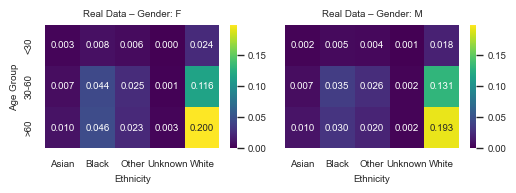

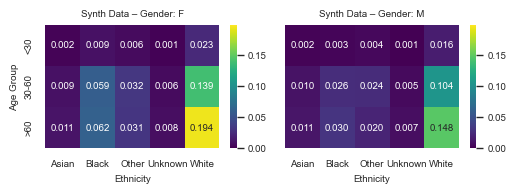

,gender,real_sum,synth_sum
0,F,0.514653,0.589623
1,M,0.485347,0.410377


In [90]:
if __name__ == "__main__":
    main(save_plots=SAVE_DATA)